In [1]:
import pandas as pd
import numpy as np
import flip_data
import gd_poisoner

In [2]:
poi_train_x = pd.read_csv('train_X.csv')
print("ori train ", poi_train_x.shape[0])
poi_train_x = np.matrix(poi_train_x.to_numpy())
print("matrix train ", len(poi_train_x))
poi_train_y = pd.read_csv('train_y.csv')
print("ori train y ", poi_train_y.shape[0])
poi_train_y = poi_train_y['Life Expectancy'].tolist()
print("matrix train y ", len(poi_train_y))
poi_test_x = pd.read_csv('test_X.csv')
poi_test_x = np.matrix(poi_test_x.to_numpy())
poi_test_y = pd.read_csv('test_y.csv')
poi_test_y = poi_test_y['Life Expectancy'].tolist()
poi_val_x = pd.read_csv('val_X.csv')
poi_val_x = np.matrix(poi_val_x.to_numpy())
poi_val_y = pd.read_csv('val_y.csv')
poi_val_y = poi_val_y['Life Expectancy'].tolist()

print (poi_train_x[0])
print (poi_train_y[0])

# num of poisoning points
poison_ct = 300
# num of points to train model
train_ct = len(poi_train_x)
test_ct = len(poi_test_x)
# proportion of poisoning
total_prop = poison_ct / (poison_ct + train_ct)
print ("Posion count: ", poison_ct, " Train count: ", train_ct, " Test count: ", test_ct, " Proportion of poisoning: ", total_prop)

ori train  1319
matrix train  1319
ori train y  1319
matrix train y  1319
[[2.00900000e+03 0.00000000e+00 2.52077562e-01 2.22222222e-03
  1.14221725e-01 6.87422107e-04 9.79591837e-01 9.89711711e-05
  2.10892236e-01 1.60000000e-03 9.79166667e-01 1.74114916e-01
  9.79381443e-01 0.00000000e+00 1.80413125e-03 1.54066216e-05
  5.50724638e-01 5.36842105e-01 7.75316456e-01 6.47342995e-01]]
0.6736242884250474
Posion count:  300  Train count:  1319  Test count:  165  Proportion of poisoning:  0.1852995676343422


# Inverse Flip & Ridge Poisoner

y_opp [0. 0. 0. ... 0. 0. 0.]
stats [0. 0. 0. ... 0. 0. 0.]
total_prob 132.78026565464893
x_pois len:  300
x_pois col ct: 20
y_pois len:  300
classifier:  Ridge(alpha=0.1, max_iter=10000)
*****************************
**** Poison Count:  51  ****
*****************************
Iteration  0 
Objective Value:  0.030486119163162396  Change:  0.030486119163162396
Validation MSE  0.005039001041191628 
Test MSE  0.007426757513414826
 
Iteration  1
Objective Value: 0.04678624708672808  Difference:  0.016300127923565683
 
Iteration  2
Objective Value: 0.046919827467796785  Difference:  0.00013358038106870557
 
Iteration  3
Objective Value: 0.04709840546619503  Difference:  0.00017857799839824523
 
Iteration  4
Objective Value: 0.04705792915809714  Difference:  -4.0476308097892044e-05
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.047095904093322837  Difference:  -2.5013728721934303e-06
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.04711991112617565  Difference:  2.150565998061682e-05

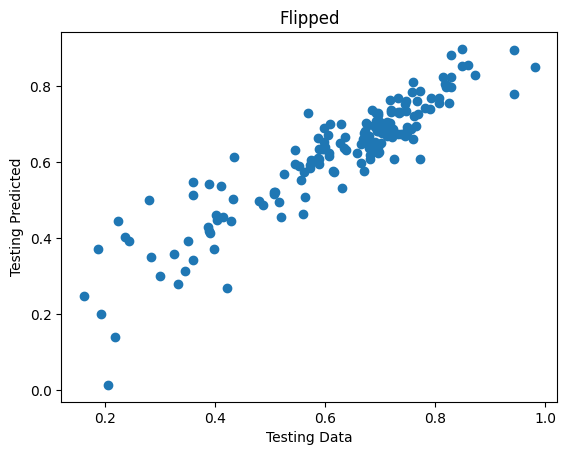

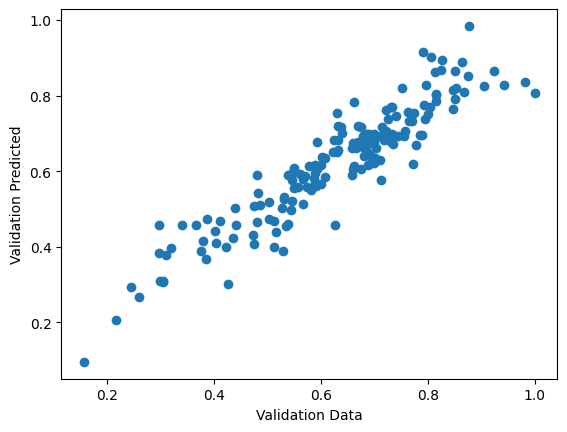

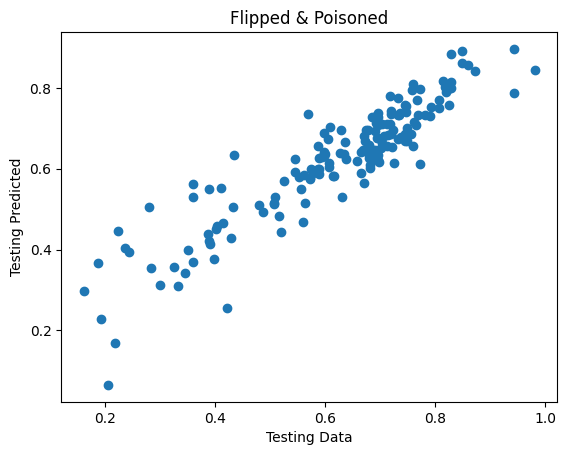

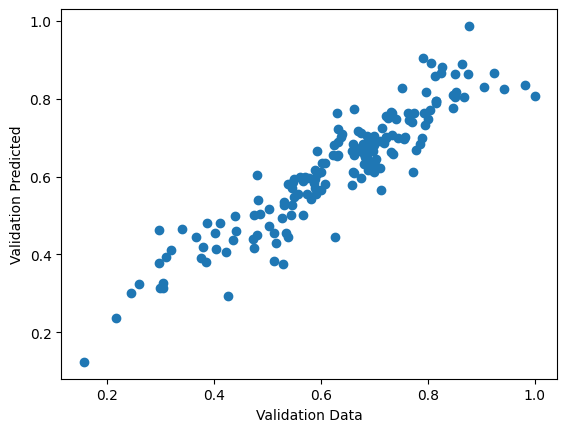

*****************************
**** Poison Count:  106  ****
*****************************
Iteration  0 
Objective Value:  0.030412969873707688  Change:  0.030412969873707688
Validation MSE  0.007938886471717236 
Test MSE  0.011241894659138366
 
Iteration  1
Objective Value: 0.04626597685440092  Difference:  0.01585300698069323
 
Iteration  2
Objective Value: 0.046266345491001025  Difference:  3.686366001065533e-07
 
Iteration  3
Objective Value: 0.04626669097968282  Difference:  3.454886817952363e-07
 
Iteration  4
Objective Value: 0.04626703660760295  Difference:  3.45627920131375e-07
 
Iteration  5
Objective Value: 0.046267381199666884  Difference:  3.4459206393194775e-07
 
Iteration  6
Objective Value: 0.046267726001983304  Difference:  3.448023164209779e-07
 
Iteration  7
Objective Value: 0.04626807133520812  Difference:  3.453332248146146e-07
 
Iteration  8
Objective Value: 0.04626841667243103  Difference:  3.453372229081375e-07
 
Iteration  9
Objective Value: 0.04626876201364709 

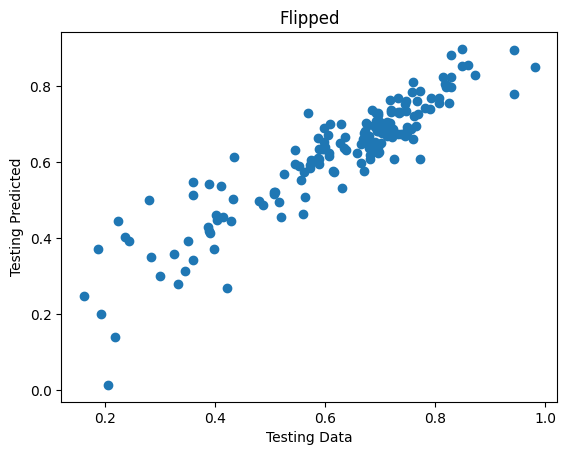

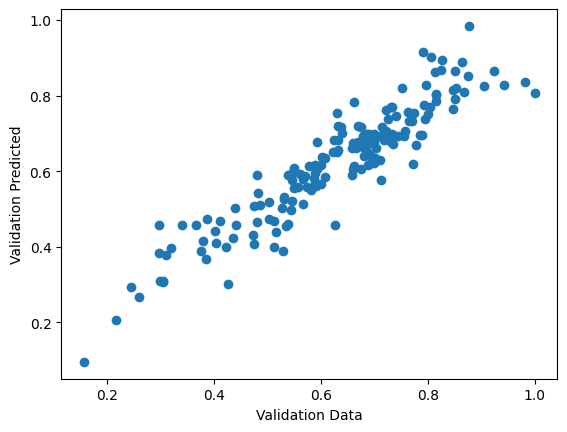

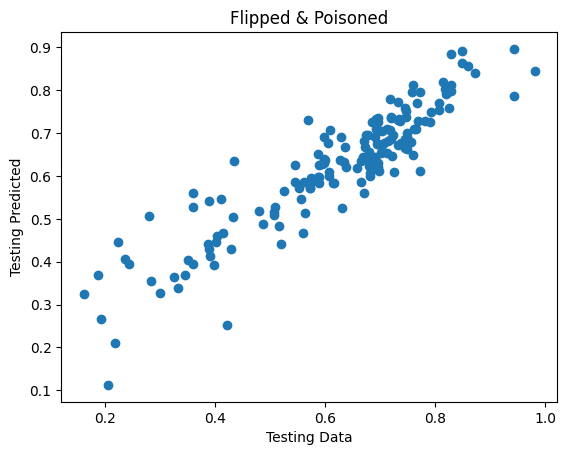

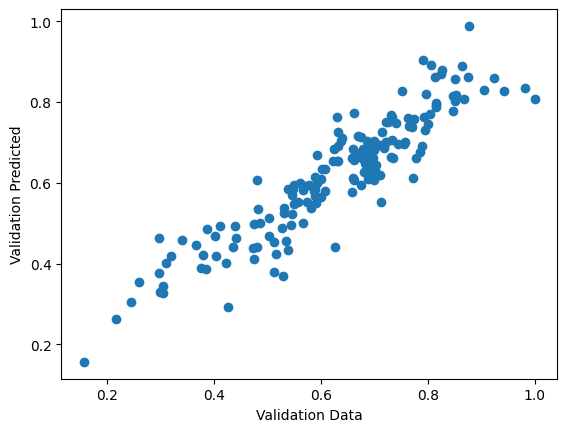

*****************************
**** Poison Count:  165  ****
*****************************
Iteration  0 
Objective Value:  0.03879301755511661  Change:  0.03879301755511661
Validation MSE  0.01214899696831105 
Test MSE  0.01647526994908859
 
Iteration  1
Objective Value: 0.044343861150268456  Difference:  0.005550843595151844
 
Iteration  2
Objective Value: 0.04434429283577334  Difference:  4.3168550488414947e-07
 
Iteration  3
Objective Value: 0.04434472440145685  Difference:  4.315656835091053e-07
 
Iteration  4
Objective Value: 0.04434515636235702  Difference:  4.319609001740554e-07
 
Iteration  5
Objective Value: 0.04434558893668722  Difference:  4.325743301961116e-07
 
Iteration  6
Objective Value: 0.0443460215186501  Difference:  4.3258196288226136e-07
 
Iteration  7
Objective Value: 0.04434645409490633  Difference:  4.325762562318314e-07
 
Iteration  8
Objective Value: 0.04434688656310909  Difference:  4.3246820275594233e-07
 
Iteration  9
Objective Value: 0.0443473190389429  Dif

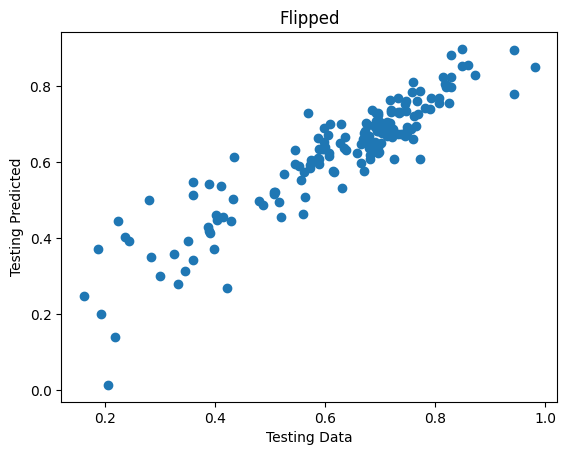

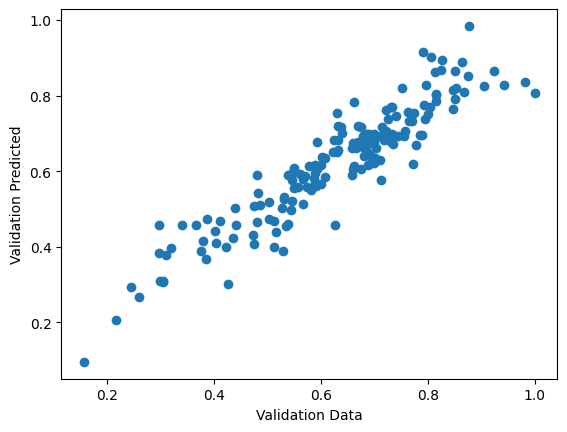

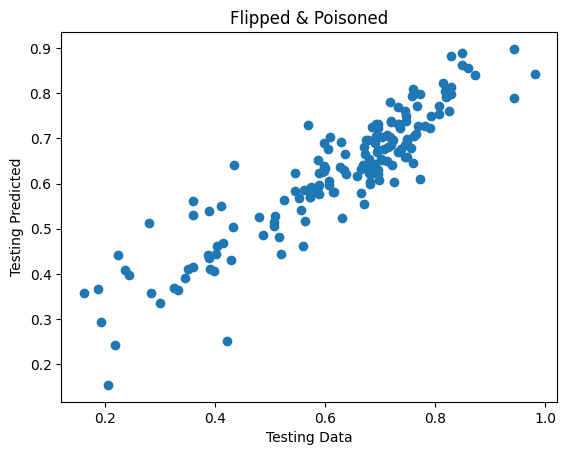

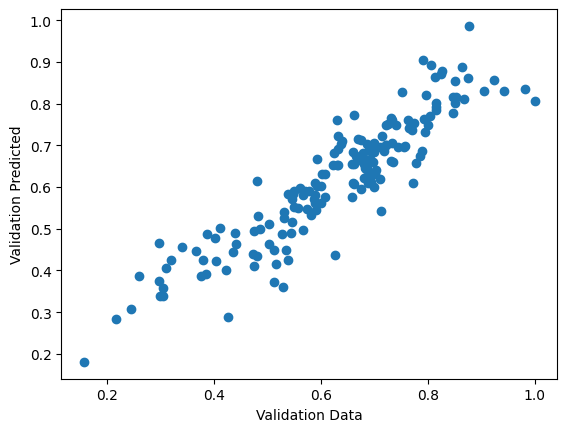

*****************************
**** Poison Count:  230  ****
*****************************
Iteration  0 
Objective Value:  0.04882551926995347  Change:  0.04882551926995347
Validation MSE  0.01651119918419925 
Test MSE  0.021211548822580174
 
Iteration  1
Objective Value: 0.0439379847160209  Difference:  -0.004887534553932565
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.043937513462776995  Difference:  -0.004888005807176472
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.04393720667967757  Difference:  -0.004888312590275896
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.04393700726636101  Difference:  -0.004888512003592457
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.04393687764588418  Difference:  -0.004888641624069288
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.04393679339180759  Difference:  -0.004888725878145879
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.043936738626330386  Difference:  -0.004888780643623081
NO PROGRESS MADE!
 
Iteration  8
Ob

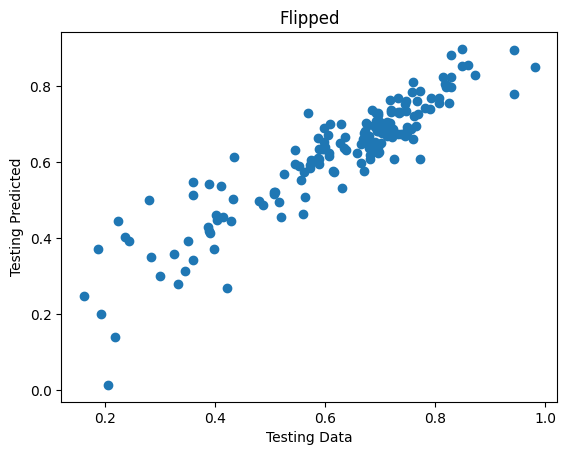

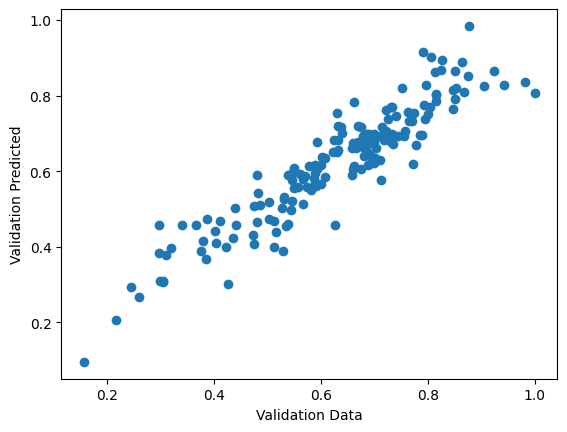

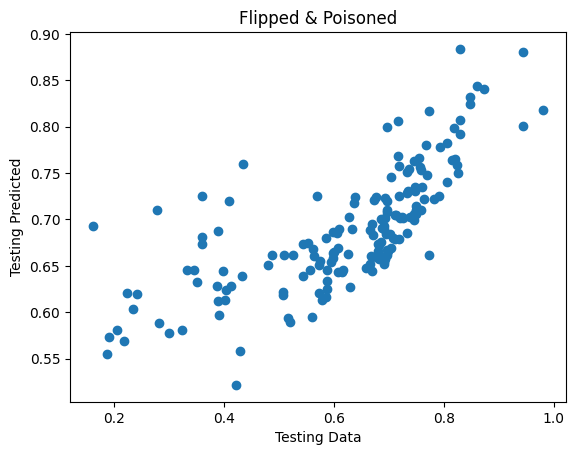

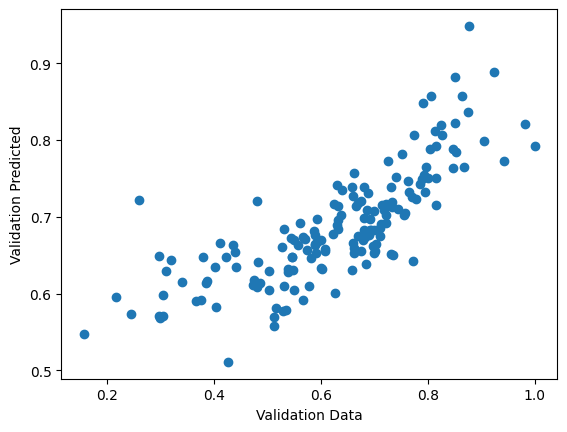

*****************************
**** Poison Count:  300  ****
*****************************
Iteration  0 
Objective Value:  0.06199479472001858  Change:  0.06199479472001858
Validation MSE  0.021554640857680347 
Test MSE  0.026578516426587925
 
Iteration  1
Objective Value: 0.04397380246743334  Difference:  -0.018020992252585237
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.04397380246264091  Difference:  -0.018020992257377667
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.04397380245952413  Difference:  -0.018020992260494445
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.043973802457497255  Difference:  -0.018020992262521324
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.04397380245618188  Difference:  -0.018020992263836695
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.04397380245532394  Difference:  -0.01802099226469464
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.04397380245477066  Difference:  -0.01802099226524792
NO PROGRESS MADE!
 
Iteration  8
Obj

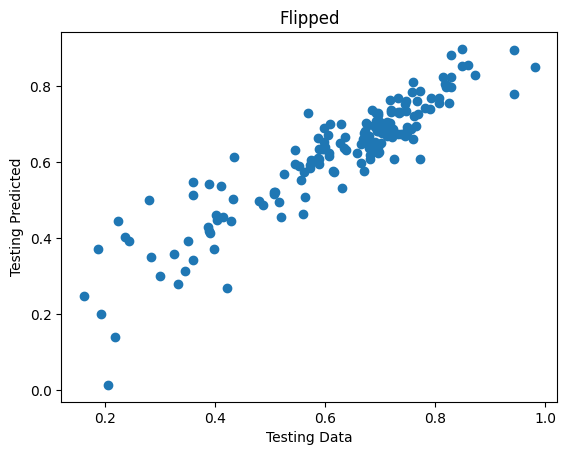

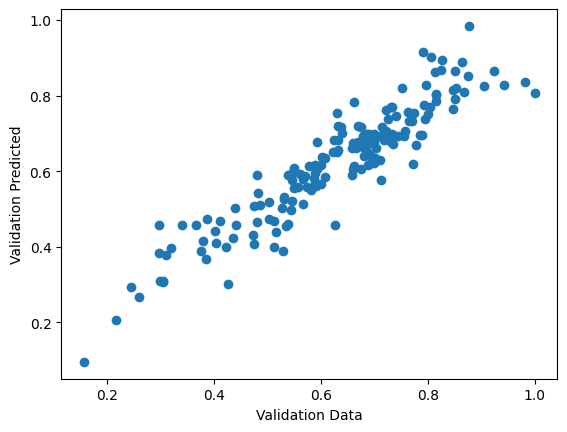

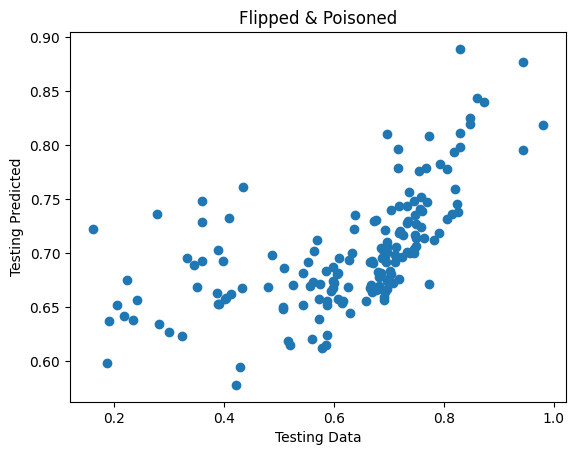

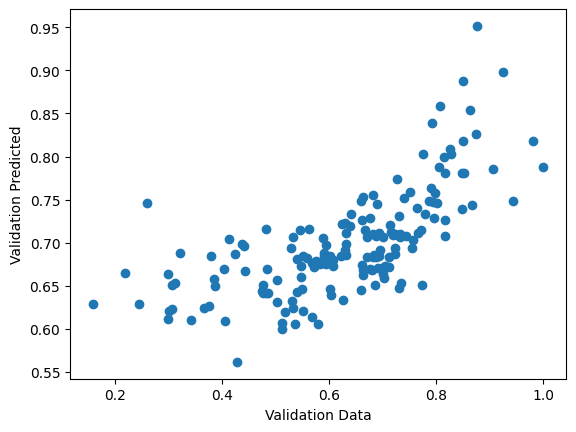


After Flipping, Unpoisoned 
 Validation MSE:  0.0037249733701270695 
 Test MSE: 0.004722250058956812

After Flipping & Poisoning:
 Validation MSE:  0.021554640857680347 
 Test MSE: 0.026578516426587925


In [3]:
# flip the data
x_pois, y_pois = flip_data.flip_data.inverse_flip(poi_train_x,poi_train_y,poison_ct)

# define parameters for poisoner
eta = 0.01 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-3 # poisoning stop condition
poiser = gd_poisoner.ridge_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier,False,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois, 20, 30)
    print(x_pois_result.shape,poi_train_x.shape)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, _ = poiser.learn_model(x_poised,y_poised,None)
    classifier = poiser.init_classifier
    print("x_pois_result len: ",len(x_pois_result),", y_pois_result len: ",len(y_pois_result),", x_poised len: ",len(x_poised),", y_poised len: ",len(y_poised))
    print("classifier_poised ",classifier_poised,", classifier2 ",classifier)
    print(" ")
    err_unpoised = poiser.compute_error(classifier,True,False)
    err = poiser.compute_error(classifier_poised,True,True)

print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])

# B Flip & Ridge Poisoner

classifier:  Ridge(alpha=0.1, max_iter=10000)
*****************************
**** Poison Count:  51  ****
*****************************
Iteration  0 
Objective Value:  0.041837046247056316  Change:  0.041837046247056316
Validation MSE  0.004129070331891705 
Test MSE  0.0055519836029705285
 
Iteration  1
Objective Value: 0.061488551732450776  Difference:  0.01965150548539446
 
Iteration  2
Objective Value: 0.05992257239765194  Difference:  -0.0015659793347988366
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.06053865122483371  Difference:  -0.000949900507617063
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.06091573401504459  Difference:  -0.0005728177174061863
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.06114135083926968  Difference:  -0.0003472008931810974
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.06128542454920511  Difference:  -0.00020312718324566603
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.06137550513604216  Difference:  -0.00011304659640861553

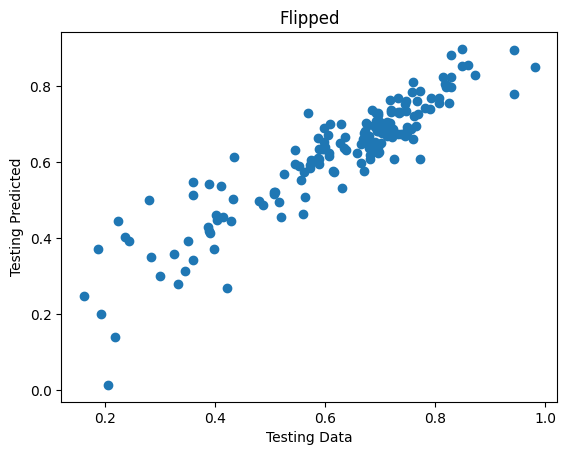

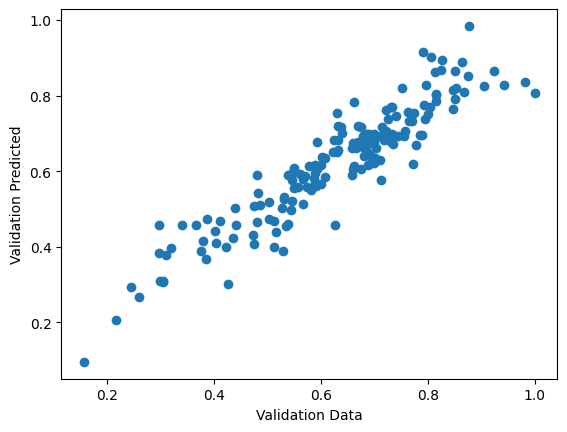

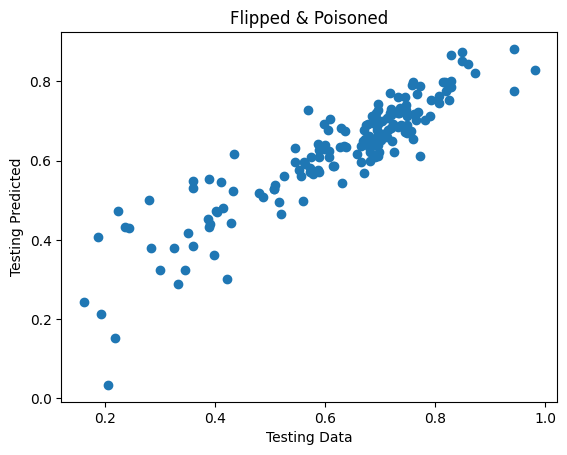

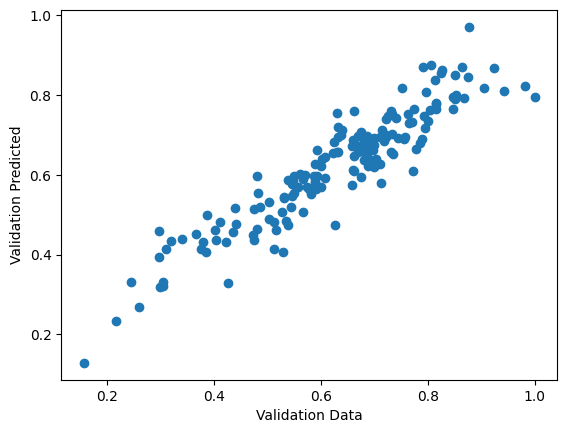

*****************************
**** Poison Count:  106  ****
*****************************
Iteration  0 
Objective Value:  0.03934547990122476  Change:  0.03934547990122476
Validation MSE  0.006472071790947852 
Test MSE  0.007383917210395949
 


KeyboardInterrupt: 

In [4]:
# flip the data
x_pois, y_pois = flip_data.flip_data.B_flip(poi_train_x,poi_train_y,poison_ct)

# define parameters for poisoner
eta = 0.01 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-3 # poisoning stop condition
poiser = gd_poisoner.ridge_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier,False,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois, 20, 30)
    print(x_pois_result.shape,poi_train_x.shape)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, _ = poiser.learn_model(x_poised,y_poised,None)
    classifier = poiser.init_classifier
    print("x_pois_result len: ",len(x_pois_result),", y_pois_result len: ",len(y_pois_result),", x_poised len: ",len(x_poised),", y_poised len: ",len(y_poised))
    print("classifier_poised ",classifier_poised,", classifier2 ",classifier)
    print(" ")
    err_unpoised = poiser.compute_error(classifier,True,False)
    err = poiser.compute_error(classifier_poised,True,True)

print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])